In [1]:
import pandas as pd
import numpy as np

file_path = "OilersData.xlsx"

raw_sheets = pd.read_excel(file_path, sheet_name=None, header=None)

def clean_csv_like_sheet(df: pd.DataFrame) -> pd.DataFrame: 
    s = df.iloc[:, 0]
    s = s.iloc[3:].reset_index(drop=True)

    s = s.dropna()
    s = s[s.astype(str).str.strip() != ""]

    split_df = s.astype(str).str.split(",", expand=True)

    split_df.columns = split_df.iloc[0].astype(str).str.strip()
    split_df = split_df.iloc[1:].reset_index(drop=True)

    split_df.columns = (
        split_df.columns
        .str.strip()
        .str.lower()
        .str.replace(" ", "_")
    ) #spilt into columns 

    split_df = split_df.dropna(axis=1, how="all").dropna(how="all")
    split_df = split_df.apply(lambda col: col.str.strip() if col.dtype == "object" else col)

    #REMOVE Hockey-Reference footer rows 
    mask_footer = split_df.astype(str).apply(
        lambda r: r.str.contains("Provided by", case=False, na=False).any(),
        axis=1
    )
    split_df = split_df[~mask_footer].reset_index(drop=True)

    return split_df


In [2]:
df_test = clean_csv_like_sheet(raw_sheets["23 playoff"])
df_test.head()

#see how it printed 

1,gp,date,hora,opponent,gf,ga,indicator,ot,w,l,ol,streak,att.,log
0,1,2024-04-22,,Los Angeles Kings,7,4,W,,1,0,W 1,18347,2:42,
1,2,2024-04-24,,Los Angeles Kings,4,5,L,OT,1,1,L 1,18347,2:51,
2,3,2024-04-26,@,Los Angeles Kings,6,1,W,,2,1,W 1,18145,2:41,
3,4,2024-04-28,@,Los Angeles Kings,1,0,W,,3,1,W 2,18145,2:18,
4,5,2024-05-01,,Los Angeles Kings,4,3,W,,4,1,W 3,18347,2:32,


In [3]:
tables = []

for name, df in raw_sheets.items():
    t = clean_csv_like_sheet(df)

    # DROP columns with blank headers
    t = t.loc[:, t.columns.astype(str).str.strip() != ""]

    # optional: keep sheet name
    t["source_sheet"] = name

    tables.append(t)

combined = pd.concat(tables, ignore_index=True)

combined.head()


1,gp,date,hora,opponent,gf,ga,indicator,ot,w,l,ol,streak,att.,log,notes,source_sheet,t
0,1,2025-10-08,,Calgary Flames,3,4,L,SO,0,0,1,L 1,18347,2:55,,25-26,NaN
1,2,2025-10-11,,Vancouver Canucks,3,1,W,,1,0,1,W 1,18347,2:33,,25-26,NaN
2,3,2025-10-14,@,New York Rangers,2,0,W,,2,0,1,W 2,16497,2:19,,25-26,NaN
3,4,2025-10-16,@,New York Islanders,2,4,L,,2,1,1,L 1,14837,2:31,,25-26,NaN
4,5,2025-10-18,@,New Jersey Devils,3,5,L,,2,2,1,L 2,16514,2:23,,25-26,NaN


In [4]:
combined['opponent'].unique()

array(['Calgary Flames', 'Vancouver Canucks', 'New York Rangers',
       'New York Islanders', 'New Jersey Devils', 'Detroit Red Wings',
       'Ottawa Senators', 'Montreal Canadiens', 'Seattle Kraken',
       'Utah Mammoth', 'Chicago Blackhawks', 'St. Louis Blues',
       'Dallas Stars', 'Colorado Avalanche', 'Columbus Blue Jackets',
       'Philadelphia Flyers', 'Carolina Hurricanes', 'Buffalo Sabres',
       'Washington Capitals', 'Tampa Bay Lightning', 'Florida Panthers',
       'Minnesota Wild', 'Winnipeg Jets', 'Toronto Maple Leafs',
       'Pittsburgh Penguins', 'Boston Bruins', 'Vegas Golden Knights',
       'Nashville Predators', 'Los Angeles Kings', 'Anaheim Ducks',
       'San Jose Sharks', 'Utah Hockey Club', 'Arizona Coyotes',
       'Phoenix Coyotes', 'Atlanta Thrashers', 'Mighty Ducks of Anaheim',
       'Hartford Whalers', 'Quebec Nordiques', 'Minnesota North Stars',
       'Chicago Black Hawks', 'Colorado Rockies', 'Atlanta Flames'],
      dtype=object)

In [5]:
#rename hora column Home or Away

combined= combined.rename(columns={"hora": "HomeOrAway"})
combined["HomeOrAway"] = combined["HomeOrAway"].replace("@", "Away")

#drop the column called t 
combined = combined.drop(columns=["t"])


In [6]:
combined["indicator"] = np.where(
    combined["gf"] > combined["ga"], "W",
    np.where(
        combined["gf"] < combined["ga"], "L",
        "T"
    )
)

#ensure Win Loss Tie calculates correctly 

In [7]:
combined.head()

1,gp,date,HomeOrAway,opponent,gf,ga,indicator,ot,w,l,ol,streak,att.,log,notes,source_sheet
0,1,2025-10-08,,Calgary Flames,3,4,L,SO,0,0,1,L 1,18347,2:55,,25-26
1,2,2025-10-11,,Vancouver Canucks,3,1,W,,1,0,1,W 1,18347,2:33,,25-26
2,3,2025-10-14,Away,New York Rangers,2,0,W,,2,0,1,W 2,16497,2:19,,25-26
3,4,2025-10-16,Away,New York Islanders,2,4,L,,2,1,1,L 1,14837,2:31,,25-26
4,5,2025-10-18,Away,New Jersey Devils,3,5,L,,2,2,1,L 2,16514,2:23,,25-26


In [8]:
combined["opponent"].unique()


array(['Calgary Flames', 'Vancouver Canucks', 'New York Rangers',
       'New York Islanders', 'New Jersey Devils', 'Detroit Red Wings',
       'Ottawa Senators', 'Montreal Canadiens', 'Seattle Kraken',
       'Utah Mammoth', 'Chicago Blackhawks', 'St. Louis Blues',
       'Dallas Stars', 'Colorado Avalanche', 'Columbus Blue Jackets',
       'Philadelphia Flyers', 'Carolina Hurricanes', 'Buffalo Sabres',
       'Washington Capitals', 'Tampa Bay Lightning', 'Florida Panthers',
       'Minnesota Wild', 'Winnipeg Jets', 'Toronto Maple Leafs',
       'Pittsburgh Penguins', 'Boston Bruins', 'Vegas Golden Knights',
       'Nashville Predators', 'Los Angeles Kings', 'Anaheim Ducks',
       'San Jose Sharks', 'Utah Hockey Club', 'Arizona Coyotes',
       'Phoenix Coyotes', 'Atlanta Thrashers', 'Mighty Ducks of Anaheim',
       'Hartford Whalers', 'Quebec Nordiques', 'Minnesota North Stars',
       'Chicago Black Hawks', 'Colorado Rockies', 'Atlanta Flames'],
      dtype=object)

In [9]:
#change names of teams that are no longer around 
combined["opponent"] = combined["opponent"].replace(
    "Mighty Ducks of Anaheim",
    "Anaheim Ducks"
)


combined["opponent"] = combined["opponent"].replace(
    "Atlanta Flames",
    "Calgary Flames"
)

combined["opponent"] = combined["opponent"].replace(
    "Chicago Black Hawks",
    "Chicago Blackhawks"
)

combined["opponent"] = combined["opponent"].replace(
    "Colorado Rockies",
    "New Jersey Devils"
)

combined["opponent"] = combined["opponent"].replace(
    "Hartford Whalers",
    "Carolina Hurricanes"
)

combined["opponent"] = combined["opponent"].replace(
    "Minnesota North Stars",
    "Dallas Stars"
)

combined["opponent"] = combined["opponent"].replace(
    "Quebec Nordiques",
    "Colorado Avalanche"
)

combined["opponent"] = combined["opponent"].replace(
    "Atlanta Thrashers",
    "Winnipeg Jets"
)

combined["opponent"] = combined["opponent"].replace({
    "Phoenix Coyotes": "Utah Mammoth",
    "Arizona Coyotes": "Utah Mammoth",
    "Utah Hockey Club": "Utah Mammoth"
})




In [10]:
combined["opponent"].unique()

array(['Calgary Flames', 'Vancouver Canucks', 'New York Rangers',
       'New York Islanders', 'New Jersey Devils', 'Detroit Red Wings',
       'Ottawa Senators', 'Montreal Canadiens', 'Seattle Kraken',
       'Utah Mammoth', 'Chicago Blackhawks', 'St. Louis Blues',
       'Dallas Stars', 'Colorado Avalanche', 'Columbus Blue Jackets',
       'Philadelphia Flyers', 'Carolina Hurricanes', 'Buffalo Sabres',
       'Washington Capitals', 'Tampa Bay Lightning', 'Florida Panthers',
       'Minnesota Wild', 'Winnipeg Jets', 'Toronto Maple Leafs',
       'Pittsburgh Penguins', 'Boston Bruins', 'Vegas Golden Knights',
       'Nashville Predators', 'Los Angeles Kings', 'Anaheim Ducks',
       'San Jose Sharks'], dtype=object)

In [11]:
import matplotlib.pyplot as plt

# Treat blank HomeOrAway as Home
combined['HomeOrAway'] = combined['HomeOrAway'].replace('', 'Home')

In [12]:
# Make indicator consistent (just in case)
combined['indicator'] = combined['indicator'].str.upper()

In [13]:
combined_clean = combined.dropna(subset=['indicator'])
combined_clean = combined_clean[combined_clean['indicator'] != '']


In [14]:
opp_summary = (
    combined_clean
    .groupby(['opponent', 'indicator'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

opp_summary


indicator,opponent,L,T,W
0,Anaheim Ducks,69,4,68
1,Boston Bruins,53,7,39
2,Buffalo Sabres,33,10,46
3,Calgary Flames,147,20,142
4,Carolina Hurricanes,37,13,47
5,Chicago Blackhawks,89,13,78
6,Colorado Avalanche,98,10,89
7,Columbus Blue Jackets,28,3,40
8,Dallas Stars,116,16,77
9,Detroit Red Wings,76,13,70


In [15]:
conference_map = {
    # WESTERN CONFERENCE
    'Calgary Flames': 'Western',
    'Vancouver Canucks': 'Western',
    'Seattle Kraken': 'Western',
    'Utah Mammoth': 'Western',
    'Utah Hockey Club': 'Western',
    'Chicago Blackhawks': 'Western',
    'Chicago Black Hawks': 'Western',
    'St. Louis Blues': 'Western',
    'Dallas Stars': 'Western',
    'Colorado Avalanche': 'Western',
    'Colorado Rockies': 'Western',
    'Minnesota Wild': 'Western',
    'Winnipeg Jets': 'Western',
    'Vegas Golden Knights': 'Western',
    'Nashville Predators': 'Western',
    'Los Angeles Kings': 'Western',
    'Anaheim Ducks': 'Western',
    'Mighty Ducks of Anaheim': 'Western',
    'San Jose Sharks': 'Western',
    'Arizona Coyotes': 'Western',
    'Phoenix Coyotes': 'Western',
    'Minnesota North Stars': 'Western',
    'Atlanta Flames': 'Western',

    # EASTERN CONFERENCE
    'New York Rangers': 'Eastern',
    'New York Islanders': 'Eastern',
    'New Jersey Devils': 'Eastern',
    'Detroit Red Wings': 'Eastern',
    'Ottawa Senators': 'Eastern',
    'Montreal Canadiens': 'Eastern',
    'Columbus Blue Jackets': 'Eastern',
    'Philadelphia Flyers': 'Eastern',
    'Carolina Hurricanes': 'Eastern',
    'Buffalo Sabres': 'Eastern',
    'Washington Capitals': 'Eastern',
    'Tampa Bay Lightning': 'Eastern',
    'Florida Panthers': 'Eastern',
    'Toronto Maple Leafs': 'Eastern',
    'Pittsburgh Penguins': 'Eastern',
    'Boston Bruins': 'Eastern',
    'Hartford Whalers': 'Eastern',
    'Quebec Nordiques': 'Eastern',
    'Atlanta Thrashers': 'Eastern'
}


In [16]:
combined['conference'] = combined['opponent'].map(conference_map)


In [17]:
combined.head()

1,gp,date,HomeOrAway,opponent,gf,ga,indicator,ot,w,l,ol,streak,att.,log,notes,source_sheet,conference
0,1,2025-10-08,Home,Calgary Flames,3,4,L,SO,0,0,1,L 1,18347,2:55,,25-26,Western
1,2,2025-10-11,Home,Vancouver Canucks,3,1,W,,1,0,1,W 1,18347,2:33,,25-26,Western
2,3,2025-10-14,Away,New York Rangers,2,0,W,,2,0,1,W 2,16497,2:19,,25-26,Eastern
3,4,2025-10-16,Away,New York Islanders,2,4,L,,2,1,1,L 1,14837,2:31,,25-26,Eastern
4,5,2025-10-18,Away,New Jersey Devils,3,5,L,,2,2,1,L 2,16514,2:23,,25-26,Eastern


In [18]:
conf_summary = (
    combined
    .groupby(['conference', 'indicator'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

conf_summary


indicator,conference,L,T,W
0,Eastern,672,121,694
1,Western,1154,169,1183


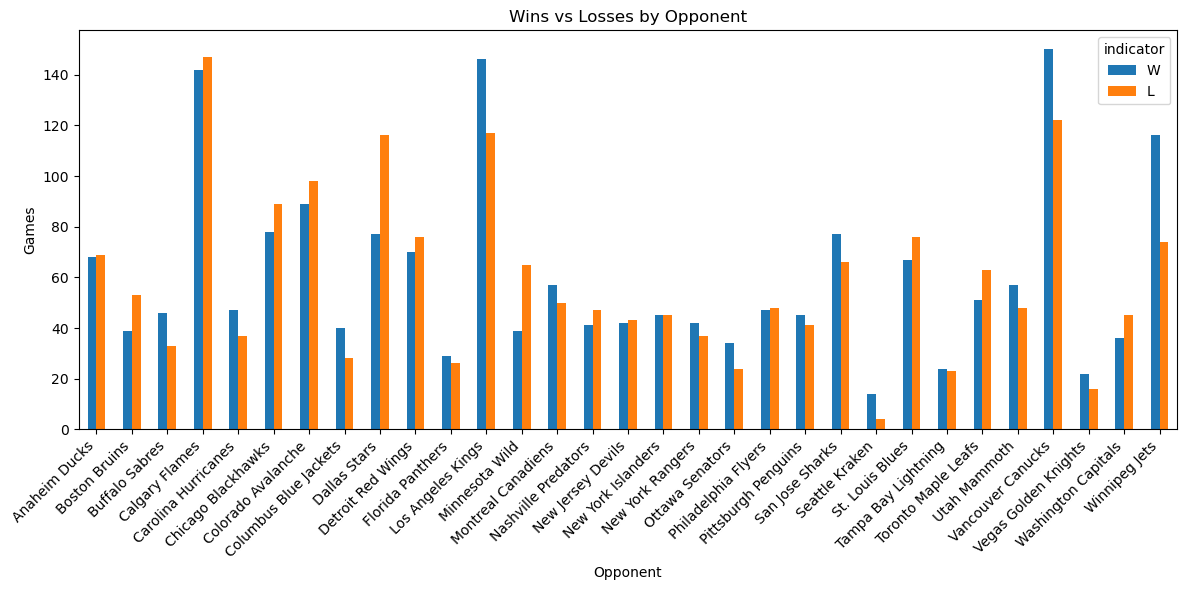

In [19]:
opp_summary.set_index('opponent')[['W','L']].plot(
    kind='bar',
    figsize=(12,6)
)

plt.title('Wins vs Losses by Opponent')
plt.ylabel('Games')
plt.xlabel('Opponent')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


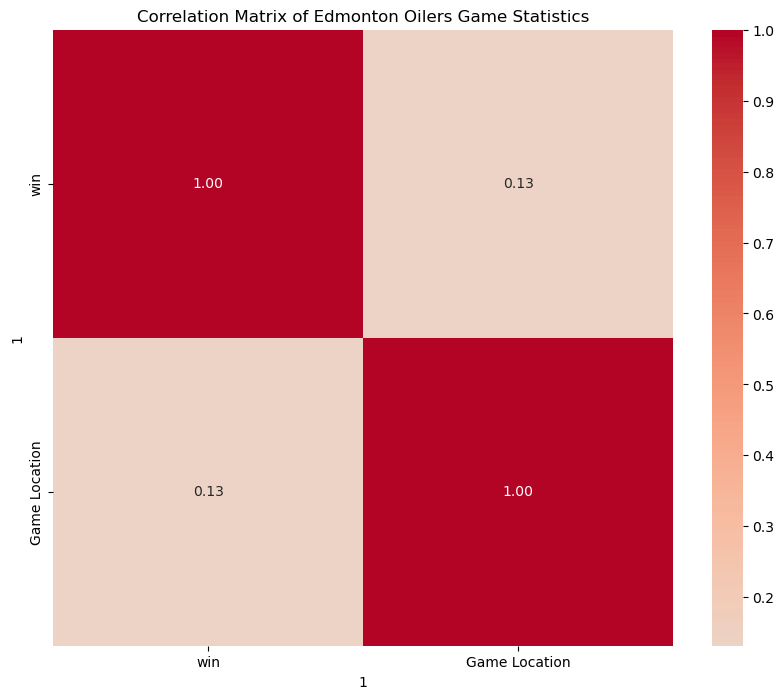

In [20]:
combined["win"] = combined["indicator"].map({"W": 1, "L": 0, "T":0})
combined["Game Location"] = combined["HomeOrAway"].map({"Home": 1, "Away": 0})
numeric_cols = combined.select_dtypes(include="number")
corr_matrix = numeric_cols.corr()
corr_with_win = (
    corr_matrix["win"]
    .sort_values(ascending=False)
)

corr_with_win

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0
)
plt.title("Correlation Matrix of Edmonton Oilers Game Statistics")
plt.show()


In [21]:
combined.head()

1,gp,date,HomeOrAway,opponent,gf,ga,indicator,ot,w,l,ol,streak,att.,log,notes,source_sheet,conference,win,Game Location
0,1,2025-10-08,Home,Calgary Flames,3,4,L,SO,0,0,1,L 1,18347,2:55,,25-26,Western,0,1.0
1,2,2025-10-11,Home,Vancouver Canucks,3,1,W,,1,0,1,W 1,18347,2:33,,25-26,Western,1,1.0
2,3,2025-10-14,Away,New York Rangers,2,0,W,,2,0,1,W 2,16497,2:19,,25-26,Eastern,1,0.0
3,4,2025-10-16,Away,New York Islanders,2,4,L,,2,1,1,L 1,14837,2:31,,25-26,Eastern,0,0.0
4,5,2025-10-18,Away,New Jersey Devils,3,5,L,,2,2,1,L 2,16514,2:23,,25-26,Eastern,0,0.0


In [22]:
file_path = "Arenas.xlsx"

arena_df = pd.read_excel(file_path)

In [23]:
arena_df.head()

,Team,Home arena,Latitude,Longitude
0,Edmonton Oilers,Rogers Place,53.546932,-113.498871
1,Calgary Flames,Scotiabank Saddledome,51.037434,-114.051934
2,Vancouver Canucks,Rogers Arena,49.276749,-123.111999
3,New York Rangers,Madison Square Garden,40.750300,-73.989500
4,New York Islanders,UBS Arena,40.722900,-73.590700


In [24]:
#Combine the arena lat lon with the combined dataframe by Opponent name 

combined = combined.merge(
    arena_df[["Team", "Latitude", "Longitude"]],
    left_on="opponent",
    right_on="Team",
    how="left"
)

In [25]:
combined[["opponent", "Latitude", "Longitude"]].head()


,opponent,Latitude,Longitude
0,Calgary Flames,51.037434,-114.051934
1,Vancouver Canucks,49.276749,-123.111999
2,New York Rangers,40.750300,-73.989500
3,New York Islanders,40.722900,-73.590700
4,New Jersey Devils,40.733500,-74.169300


In [26]:
import numpy as np

EDM_LAT = 53.546932
EDM_LON = -113.498871

is_home = combined["HomeOrAway"].astype(str).str.strip().str.lower().eq("home")

combined["game_lat"] = np.where(is_home, EDM_LAT, combined["Latitude"])
combined["game_lon"] = np.where(is_home, EDM_LON, combined["Longitude"])



In [27]:
combined["date"] = pd.to_datetime(combined["date"], errors="coerce")

combined = combined.sort_values(
    ["source_sheet", "date", "gp"],
    kind="mergesort"
).reset_index(drop=True)


In [28]:
import numpy as np

def haversine_vec(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1 = np.radians(lat1); lon1 = np.radians(lon1)
    lat2 = np.radians(lat2); lon2 = np.radians(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

# Make sure order is correct before shifting
combined = combined.sort_values(["source_sheet", "date", "gp"], kind="mergesort").reset_index(drop=True)

prev_lat = combined.groupby("source_sheet")["game_lat"].shift(1)
prev_lon = combined.groupby("source_sheet")["game_lon"].shift(1)

combined["travel_km"] = haversine_vec(
    prev_lat, prev_lon,
    combined["game_lat"], combined["game_lon"]
).fillna(0)

# Reset home games to 0 (use HomeOrAway since you have it)
is_home = combined["HomeOrAway"].astype(str).str.strip().str.lower().eq("home")
combined.loc[is_home, "travel_km"] = 0

combined["travel_km"] = combined["travel_km"].round(1)


In [29]:
# make sure win exists
combined["win"] = (combined["indicator"] == "W").astype(int)

# recreate travel distance bins
bins = [0, 500, 1000, 1500, 2000, 2500, 3000, 5000]
labels = ["0–500","500–1000","1000–1500","1500–2000","2000–2500","2500–3000","3000+"]

combined["dist_bin"] = pd.cut(
    combined["travel_km"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# THIS is the missing variable
win_rate = combined.groupby("dist_bin", observed=True)["win"].mean()


In [30]:
combined.columns

Index(['gp', 'date', 'HomeOrAway', 'opponent', 'gf', 'ga', 'indicator', 'ot',
       'w', 'l', 'ol', 'streak', 'att.', 'log', 'notes', 'source_sheet',
       'conference', 'win', 'Game Location', 'Team', 'Latitude', 'Longitude',
       'game_lat', 'game_lon', 'travel_km', 'dist_bin'],
      dtype='object')

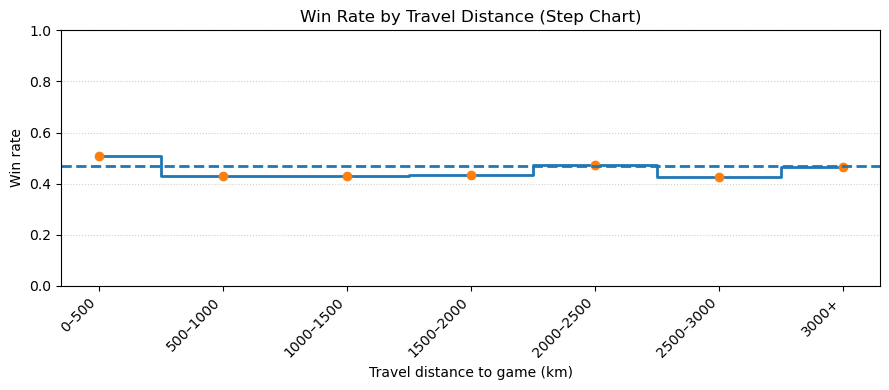

In [31]:
import matplotlib.pyplot as plt
import numpy as np



# x positions for bins
x = np.arange(len(win_rate))
y = win_rate.values

mean_win_rate = combined["win"].mean()

plt.figure(figsize=(9,4))

plt.step(
    x,
    y,
    where="mid",
    linewidth=2
)

# markers help a LOT with readability
plt.plot(x, y, "o")

# reference line (overall win rate)
plt.axhline(
    mean_win_rate,
    linestyle="--",
    linewidth=2
)

# labels and ticks
plt.xticks(x, win_rate.index, rotation=45, ha="right")
plt.ylabel("Win rate")
plt.xlabel("Travel distance to game (km)")
plt.title("Win Rate by Travel Distance (Step Chart)")

plt.ylim(0, 1)
plt.grid(axis="y", linestyle=":", alpha=0.6)
plt.tight_layout()
plt.show()


In [32]:
combined["days_rest"] = (
    combined.groupby("source_sheet")["date"]
    .diff()
    .dt.days
    .fillna(0)
)

combined.groupby(
    pd.cut(combined["days_rest"], [0,1,2,3,5,10]),
    observed=True
)["win"].mean()



days_rest
(0, 1]     0.394127
(1, 2]     0.485741
(2, 3]     0.490667
(3, 5]     0.474820
(5, 10]    0.450000
Name: win, dtype: float64

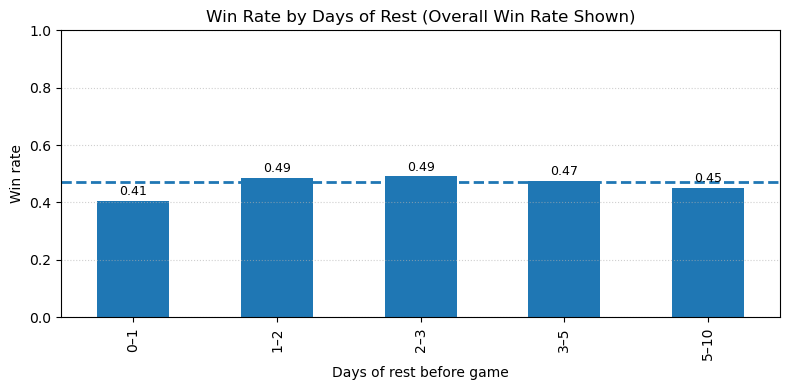

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Make sure date + win exist
combined["date"] = pd.to_datetime(combined["date"], errors="coerce")
combined["win"] = combined["indicator"].map({"W": 1, "L": 0, "T":0})

# 2) Days rest within each season
combined["days_rest"] = (
    combined.groupby("source_sheet")["date"]
    .diff()
    .dt.days
    .fillna(0)
)

# 3) Bin days rest
bins = [0, 1, 2, 3, 5, 10]
labels = ["0–1", "1–2", "2–3", "3–5", "5–10"]

combined["rest_bin"] = pd.cut(
    combined["days_rest"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# 4) Win rate by rest bin
win_rate_rest = combined.groupby("rest_bin", observed=True)["win"].mean()
overall_win_rate = combined["win"].mean()

# 5) Plot bar chart
ax = win_rate_rest.plot(kind="bar", figsize=(8,4))

# overall win-rate reference line
plt.axhline(overall_win_rate, linestyle="--", linewidth=2)

# value labels on bars
for i, v in enumerate(win_rate_rest.values):
    ax.text(i, v + 0.02, f"{v:.2f}", ha="center", fontsize=9)

plt.ylabel("Win rate")
plt.xlabel("Days of rest before game")
plt.title("Win Rate by Days of Rest (Overall Win Rate Shown)")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle=":", alpha=0.6)
plt.tight_layout()
plt.show()


In [34]:
#Road trip accumulation 

import numpy as np
import pandas as pd

# make sure sorted correctly first
combined = combined.sort_values(["source_sheet", "date", "gp"], kind="mergesort").reset_index(drop=True)

# ensure is_home exists and is boolean
combined["is_home"] = (
    combined["HomeOrAway"].astype(str).str.strip().str.lower().eq("home")
)

# trip_id increments each time we hit a home game (within a season)
combined["trip_id"] = combined.groupby("source_sheet")["is_home"].cumsum()

# accumulated travel within each "trip segment"
combined["accum_travel_km"] = (
    combined.groupby(["source_sheet", "trip_id"])["travel_km"]
    .cumsum()
)

# reset at home games (by definition)
combined.loc[combined["is_home"], "accum_travel_km"] = 0
combined["accum_travel_km"] = combined["accum_travel_km"].round(1)


In [35]:
combined["date"] = pd.to_datetime(combined["date"], errors="coerce")

combined.sort_values(
    by=["date"],
    ascending=True
)[["source_sheet", "date", "HomeOrAway", "opponent", "travel_km", "accum_travel_km"]].head(25)


,source_sheet,date,HomeOrAway,opponent,travel_km,accum_travel_km
2116,79-80,1979-10-10,Away,Chicago Blackhawks,0.0,0.0
2117,79-80,1979-10-13,Home,Detroit Red Wings,0.0,0.0
2118,79-80,1979-10-14,Home,Vancouver Canucks,0.0,0.0
2119,79-80,1979-10-19,Home,Colorado Avalanche,0.0,0.0
2120,79-80,1979-10-21,Home,Dallas Stars,0.0,0.0
2121,79-80,1979-10-23,Away,New York Islanders,3282.7,3282.7
2122,79-80,1979-10-24,Away,New York Rangers,33.7,3316.4
2123,79-80,1979-10-26,Away,Calgary Flames,3257.0,6573.4
2124,79-80,1979-10-28,Home,Washington Capitals,0.0,0.0
2125,79-80,1979-10-30,Away,St. Louis Blues,2424.7,2424.7


In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# make sure win exists
combined["win"] = combined["indicator"].map({"W": 1, "L": 0, "T":0})

# bins for accumulated travel (km)
bins = [0, 500, 1000, 1500, 2000, 3000, 5000, 10000]
labels = ["0–500","500–1000","1000–1500","1500–2000","2000–3000","3000–5000","5000+"]

combined["accum_bin"] = pd.cut(
    combined["accum_travel_km"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

accum_win_rate = combined.groupby("accum_bin", observed=True)["win"].mean()
overall_win_rate = combined["win"].mean()



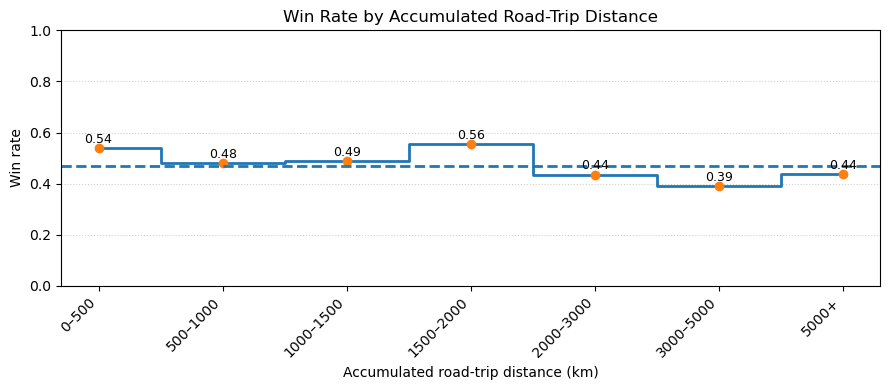

In [37]:
import numpy as np

x = np.arange(len(accum_win_rate))
y = accum_win_rate.values

plt.figure(figsize=(9,4))

plt.step(x, y, where="mid", linewidth=2)
plt.plot(x, y, "o")

# overall reference line
plt.axhline(overall_win_rate, linestyle="--", linewidth=2)

# labels
plt.xticks(x, accum_win_rate.index, rotation=45, ha="right")
plt.ylabel("Win rate")
plt.xlabel("Accumulated road-trip distance (km)")
plt.title("Win Rate by Accumulated Road-Trip Distance")

# value labels (VERY helpful)
for i, v in enumerate(y):
    plt.text(i, v + 0.02, f"{v:.2f}", ha="center", fontsize=9)

plt.ylim(0, 1)
plt.grid(axis="y", linestyle=":", alpha=0.6)
plt.tight_layout()
plt.show()


In [38]:
output_path = "Oilers_All_Seasons.xlsx"

combined.to_excel(output_path, index=False)

In [39]:
combined["is_home"] = combined["is_home"].astype(int)
#convert to numeric 

In [40]:
corr_cols = [
    "win",
    "is_home",
    "days_rest",
    "travel_km",
    "accum_travel_km"
]

corr = combined[corr_cols].corr()

# show correlation with win
corr["win"].sort_values(ascending=False)


win                1.000000
is_home            0.095586
days_rest          0.006517
accum_travel_km   -0.028298
travel_km         -0.049965
Name: win, dtype: float64

In [41]:
combined["back_to_back"] = (combined["days_rest"] <= 1).astype(int)

combined["days_rest_sq"] = combined["days_rest"] ** 2

combined[["days_rest", "days_rest_sq", "back_to_back"]].head()

combined[["win", "days_rest", "days_rest_sq", "back_to_back"]].corr()["win"]



win             1.000000
days_rest       0.006517
days_rest_sq   -0.018712
back_to_back   -0.060629
Name: win, dtype: float64

In [42]:
#rolling win percentage for teams 
combined = combined.sort_values(["source_sheet", "date", "gp"]).reset_index(drop=True)

combined["rolling_win_pct_10"] = (
    combined.groupby("source_sheet")["win"]
    .rolling(window=10, min_periods=5)
    .mean()
    .reset_index(level=0, drop=True)
)

combined["rolling_win_pct_10"] = combined["rolling_win_pct_10"].fillna(0.5)


In [43]:
#Win % 
combined["season_games_played"] = combined.groupby("source_sheet").cumcount()
combined["season_wins_to_date"] = combined.groupby("source_sheet")["win"].cumsum()

combined["season_win_pct"] = (
    combined["season_wins_to_date"] /
    combined["season_games_played"].replace(0, np.nan)
)


In [44]:
combined[["rolling_win_pct_10", "season_win_pct"]].corr()


,rolling_win_pct_10,season_win_pct
rolling_win_pct_10,1.000000,0.522899
season_win_pct,0.522899,1.000000


In [45]:
import numpy as np
import pandas as pd

features = [
    "is_home",
    "accum_travel_km",
    "back_to_back",
    "rolling_win_pct_10"
]

X = combined[features].copy()
y = combined["win"].copy()


In [46]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X[["accum_travel_km", "rolling_win_pct_10"]] = scaler.fit_transform(
    X[["accum_travel_km", "rolling_win_pct_10"]]
)


In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)


In [48]:
import statsmodels.api as sm

X_train_sm = sm.add_constant(X_train)
model = sm.Logit(y_train, X_train_sm)
result = model.fit()

result.summary()


Optimization terminated successfully.
         Current function value: 0.618846
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    win   No. Observations:                 2994
Model:                          Logit   Df Residuals:                     2989
Method:                           MLE   Df Model:                            4
Date:                Mon, 09 Feb 2026   Pseudo R-squ.:                  0.1049
Time:                        22:11:43   Log-Likelihood:                -1852.8
converged:                       True   LL-Null:                       -2069.9
Covariance Type:            nonrobust   LLR p-value:                 1.194e-92
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.2011      0.052     -3.904      0.000      -0.302      -0.100
is_home                0.4375      0.102      4.309      0.000       0.238       0.636
accum_travel_km        0.0405      0.044      0.918      0.359      -0.046       0.127
back_to_back          -0.3055      0.102     -3.000      0.003      -0.505      -0.106
rolling_win_pct_10     0.8022      0.044     18.116      0.000       0.715       0.889
======================================================================================
"""